In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

In [3]:
train_data = pd.read_csv(r"D:\Jupyter\Egyptian_script\train\_annotations.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2723 entries, 0 to 2722
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2723 non-null   object
 1   width     2723 non-null   int64 
 2   height    2723 non-null   int64 
 3   class     2723 non-null   object
 4   xmin      2723 non-null   int64 
 5   ymin      2723 non-null   int64 
 6   xmax      2723 non-null   int64 
 7   ymax      2723 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 170.3+ KB


In [4]:
valid_data = pd.read_csv(r"D:\Jupyter\Egyptian_script\valid\_annotations.csv")
test_data = pd.read_csv(r"D:\Jupyter\Egyptian_script\test\_annotations.csv")

In [5]:
import os
import cv2
import numpy as np
import torch
import gc
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import OrdinalEncoder

# 数据文件夹路径
train_folder = "D:/Jupyter/Egyptian_script/train/"
valid_folder = "D:/Jupyter/Egyptian_script/valid/"
test_folder = "D:/Jupyter/Egyptian_script/test/"

def preprocess_image(image):
    # 调整图像大小
    target_size = (640, 640)
    image = cv2.resize(image, target_size)
    
    # 归一化到0到1之间的范围
    image = image / 255.0
    
    # 转换为PyTorch张量并添加批次维度
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    
    return image_tensor

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                preprocessed_img = preprocess_image(img)
                images.append(preprocessed_img)
    return images


train_images = load_images_from_folder(train_folder)
valid_images = load_images_from_folder(valid_folder)
test_images = load_images_from_folder(test_folder)

train_images = torch.cat(train_images, dim=0)
valid_images = torch.cat(valid_images, dim=0)
test_images = torch.cat(test_images, dim=0)

train_labels = train_data['class'].tolist()
valid_labels = valid_data['class'].tolist()
test_labels = test_data['class'].tolist()

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)


from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
train_labels = encoder.fit_transform([train_labels])
valid_labels = encoder.fit_transform([valid_labels])
test_labels = encoder.fit_transform([test_labels])
train_labels = train_labels.flatten()
valid_labels = valid_labels.flatten()
test_labels = test_labels.flatten()
import gc
del(train_data)
del(valid_data)
del(test_data)

gc.collect()


# I am clearing the RAM from time to time as the memory need is exceeding the available memory :/


0

In [6]:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 将数据转换为 PyTorch 张量

train_labels = torch.tensor(train_labels, dtype=torch.int64)

valid_labels = torch.tensor(valid_labels, dtype=torch.int64)

test_labels = torch.tensor(test_labels, dtype=torch.int64)

# 创建用于训练的 DataLoader
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# 创建用于验证的 DataLoader
valid_dataset = TensorDataset(valid_images, valid_labels)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# 在 PyTorch 中定义模型
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=4, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # First max pool
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # Second max pool
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # Third max pool
        
        # Calculate the size of the linear layer input
        self.fc_input_size = self.calculate_conv_output_size(80, 4, 1, 1)  # Assuming conv1's parameters
        self.fc1 = nn.Linear(32 * self.fc_input_size * self.fc_input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        # Reshape the tensor before passing it through fully connected layers
        x = x.view(-1, 32 * self.fc_input_size * self.fc_input_size)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        x = self.fc3(x)
        return x
    
    # Function to calculate the output size of convolutional layers
    def calculate_conv_output_size(self, image_size, kernel_size, padding, stride):
        return ((image_size - kernel_size + 2 * padding) // stride) + 1
    
model = CustomCNN()


# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 存储训练历史数据
history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

# 训练循环
for epoch in range(10):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # 计算训练准确率
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
    # 计算验证集上的损失和准确率
    valid_loss = 0.0
    correct_predictions_valid = 0
    total_predictions_valid = 0
    
    model.eval()  # 将模型切换到评估模式
    with torch.no_grad():
        for inputs_valid, labels_valid in valid_loader:  # 假设你有一个验证集的 DataLoader
            outputs_valid = model(inputs_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            valid_loss += loss_valid.item()

            _, predicted_valid = torch.max(outputs_valid, 1)
            total_predictions_valid += labels_valid.size(0)
            correct_predictions_valid += (predicted_valid == labels_valid).sum().item()

    valid_accuracy = correct_predictions_valid / total_predictions_valid
    valid_loss /= len(valid_loader)
    
    # 将当前 epoch 的训练和验证数据记录到 history 字典中
    history['loss'].append(running_loss / len(train_loader))
    history['accuracy'].append(correct_predictions / total_predictions)
    history['val_loss'].append(valid_loss)
    history['val_accuracy'].append(valid_accuracy)
    
    print(f"第 {epoch+1} 轮，损失：{running_loss / len(train_loader)}")
    print(f"第 {epoch+1} 轮，验证损失：{valid_loss}, 验证准确率：{valid_accuracy}")

# 在测试数据上进行评估
with torch.no_grad():
    test_outputs = model(test_images)
    _, predicted = torch.max(test_outputs, 1)
    correct = (predicted == test_labels).sum().item()
    total = test_labels.size(0)
    accuracy = correct / total
    print(f"测试准确率：{accuracy}")

第 1 轮，损失：0.944885984929495
第 1 轮，验证损失：0.27713837295770644, 验证准确率：0.890745501285347
第 2 轮，损失：0.17981759022222832
第 2 轮，验证损失：0.19271910801529885, 验证准确率：0.9215938303341902
第 3 轮，损失：0.11540361350673807
第 3 轮，验证损失：0.07321843586163596, 验证准确率：0.9730077120822622
第 4 轮，损失：0.06048357989486464
第 4 轮，验证损失：0.05261789727492193, 验证准确率：0.987146529562982
第 5 轮，损失：0.07802527241100485
第 5 轮，验证损失：0.06447098676657063, 验证准确率：0.9858611825192802
第 6 轮，损失：0.04576115691500794
第 6 轮，验证损失：0.039665839206493275, 验证准确率：0.9961439588688946
第 7 轮，损失：0.042376004114495144
第 7 轮，验证损失：0.01618270610780151, 验证准确率：0.9987146529562982
第 8 轮，损失：0.04729310686088404
第 8 轮，验证损失：0.04183873651457303, 验证准确率：0.9948586118251928
第 9 轮，损失：0.028211467092875298
第 9 轮，验证损失：0.036867427701703405, 验证准确率：0.9961439588688946
第 10 轮，损失：0.032419739194895464
第 10 轮，验证损失：0.04032011188607235, 验证准确率：0.9974293059125964
测试准确率：0.9948586118251928


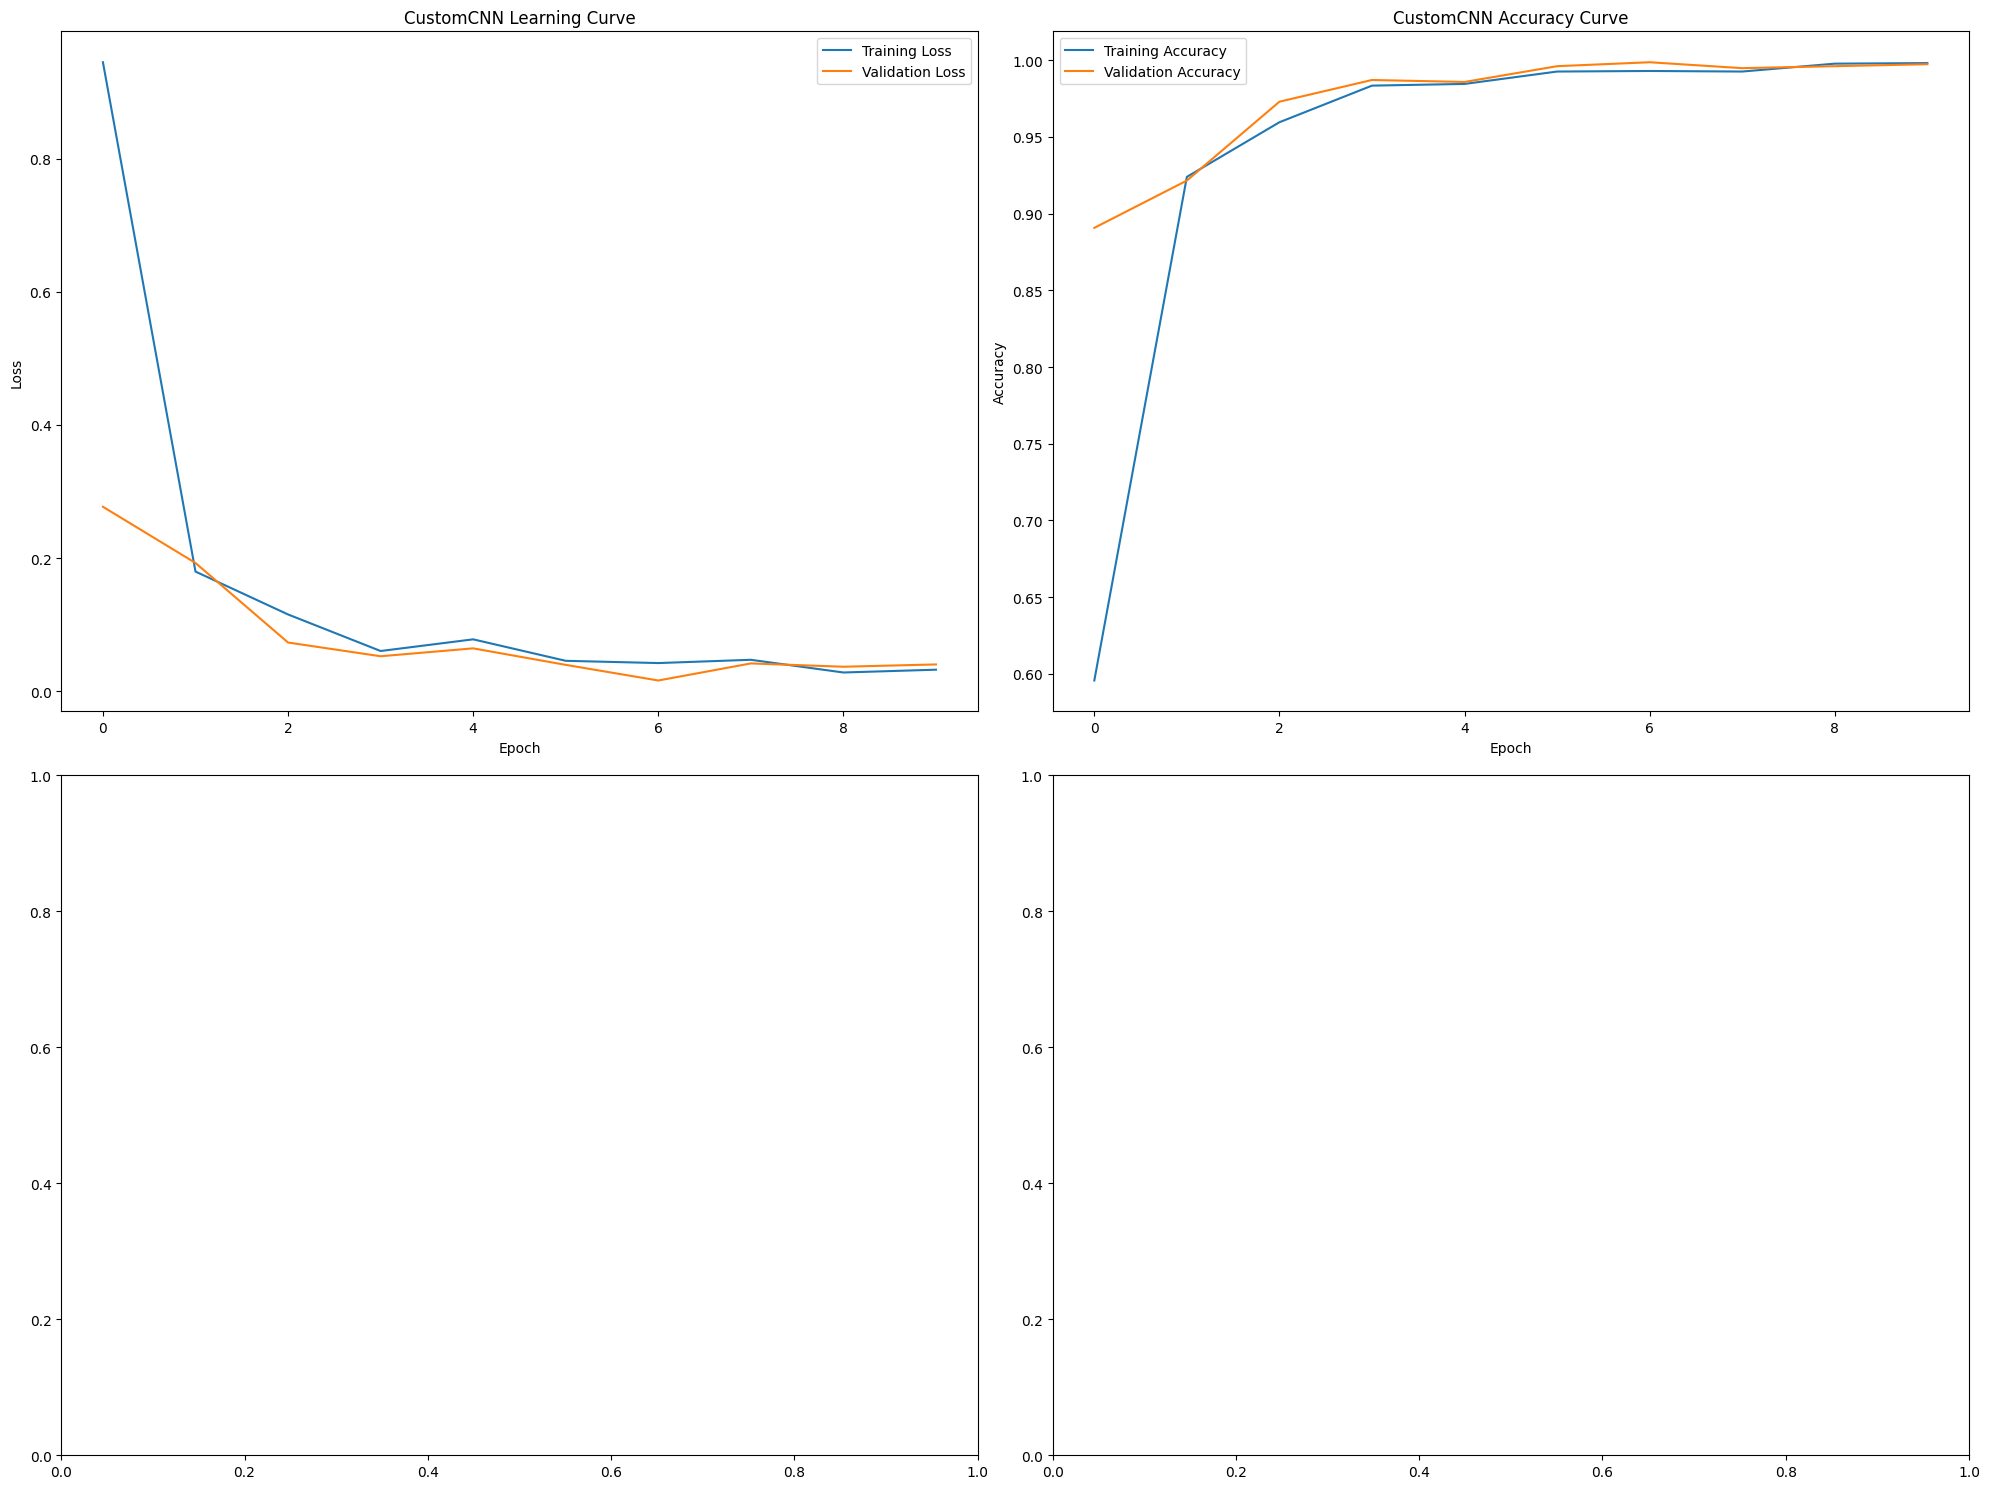

In [7]:
# 绘制学习曲线
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs[0, 0].plot(history['loss'], label='Training Loss')
axs[0, 0].plot(history['val_loss'], label='Validation Loss')
axs[0, 0].set_title('CustomCNN Learning Curve')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

axs[0, 1].plot(history['accuracy'], label='Training Accuracy')
axs[0, 1].plot(history['val_accuracy'], label='Validation Accuracy')
axs[0, 1].set_title('CustomCNN Accuracy Curve')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

plt.tight_layout()
plt.show()